In [1]:
import json

import pandas as pd

In [2]:
hotels = pd.read_csv('hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


Смотрим на пропуски

In [3]:
hotels.isna().sum().sort_values(ascending=False)

lng                                           2448
lat                                           2448
positive_review                                  0
days_since_review                                0
tags                                             0
reviewer_score                                   0
total_number_of_reviews_reviewer_has_given       0
review_total_positive_word_counts                0
hotel_address                                    0
additional_number_of_scoring                     0
review_total_negative_word_counts                0
negative_review                                  0
reviewer_nationality                             0
hotel_name                                       0
average_score                                    0
review_date                                      0
total_number_of_reviews                          0
dtype: int64

Заполняем пропуски значениями из словарей, заранее подготовленных скриптом prepare_lat_lng_dicts.py с применением библиотеки geopy

In [4]:
with open("lng_dict.json", "r") as infile:
    lng_dict = json.load(infile)

In [5]:
with open("lat_dict.json", "r") as infile:
    lat_dict = json.load(infile)

In [6]:
missings_idx = hotels[hotels.lng.isna()].index
hotels.loc[missings_idx, 'lat'] = hotels.loc[missings_idx, 'hotel_address'].map(lat_dict)
hotels.loc[missings_idx, 'lng'] = hotels.loc[missings_idx, 'hotel_address'].map(lng_dict)

In [7]:
hotels.isna().sum().sum()

0

От пропусков избавились. Обратим внимание на признаки, представленные в виде строк:

Дополним датасет данными о стране и городе, в которых располагается отель

In [8]:
with open("countries.json", "r", encoding='UTF-8') as infile:
    countries = json.load(infile)

with open("cities.json", "r", encoding='UTF-8') as infile:
    cities = json.load(infile)

In [9]:
hotels['hotel_country'] = hotels.hotel_name.map(countries)
hotels['hotel_city'] = hotels.hotel_name.map(cities)

In [10]:
hotels.hotel_country.value_counts()

United Kingdom    196774
France             44830
Nederland          43006
Espanya            35356
Österreich         28956
Italia             27836
España             10045
Name: hotel_country, dtype: int64

In [11]:
hotels.hotel_city.value_counts()

London                      140937
Barcelona                    45307
Paris                        39652
Amsterdam                    35914
Milano                       22307
                             ...  
Vanves                          29
Montrouge                       25
Paris 4e Arrondissement         18
Paris 10e Arrondissement         7
Ottakring                        6
Name: hotel_city, Length: 62, dtype: int64

In [12]:
hotels.isna().sum().sum()

0

Пропусков нет

Добавим данные о расстояниях от отелей до центров городов

In [13]:
from geopy.geocoders import ArcGIS

In [14]:
from geopy.distance import geodesic

In [15]:
locator = ArcGIS(user_agent='myGeocoder')

In [16]:
def get_distance(lat1, lng1, lat2, lng2):
    distance = geodesic(
        (lat1, lng1),
        (lat2, lng2)
    ).kilometers
    
    return distance

In [17]:
from tqdm import tqdm

In [24]:
hotels['hotel_location'] = hotels.hotel_city + ',' + hotels.hotel_country

In [25]:
hotels.hotel_location

0         London,United Kingdom
1         London,United Kingdom
2                  Paris,France
3                  Paris,France
4           Amsterdam,Nederland
                  ...          
386798    London,United Kingdom
386799    Landstraße,Österreich
386800    London,United Kingdom
386801    London,United Kingdom
386802    London,United Kingdom
Name: hotel_location, Length: 386803, dtype: object

In [27]:
hotels_cities_centers_lats = {}
hotels_cities_centers_lngs = {}

for location in tqdm(hotels.hotel_location.unique()):
    city_center_coordinates = locator.geocode(location)
    hotels_cities_centers_lats[location] = city_center_coordinates.latitude
    hotels_cities_centers_lngs[location] = city_center_coordinates.longitude


100%|██████████| 63/63 [00:47<00:00,  1.34it/s]


In [28]:
hotels['city_center_lat'] = hotels['hotel_location'].map(hotels_cities_centers_lats)
hotels['city_center_lng'] = hotels['hotel_location'].map(hotels_cities_centers_lngs)


In [29]:
tqdm.pandas()

In [30]:
hotels['dist_to_center'] = hotels[['city_center_lat', 'city_center_lng', 'lat', 'lng']].progress_apply(
    lambda x: get_distance(
        x['city_center_lat'],
        x['city_center_lng'],
        x['lat'],
        x['lng']
    ),
    axis=1
)

100%|██████████| 386803/386803 [02:03<00:00, 3120.78it/s]


In [31]:
hotels.isna().sum().sum()

0

In [32]:
hotels.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   hotel_address         386803 non-null  object
 1   review_date           386803 non-null  object
 2   hotel_name            386803 non-null  object
 3   reviewer_nationality  386803 non-null  object
 4   negative_review       386803 non-null  object
 5   positive_review       386803 non-null  object
 6   tags                  386803 non-null  object
 7   days_since_review     386803 non-null  object
 8   hotel_country         386803 non-null  object
 9   hotel_city            386803 non-null  object
 10  hotel_location        386803 non-null  object
dtypes: object(11)
memory usage: 32.5+ MB


Начнём с hotel_address

In [33]:
hotels.hotel_address.describe()

count                                                386803
unique                                                 1493
top       163 Marsh Wall Docklands Tower Hamlets London ...
freq                                                   3587
Name: hotel_address, dtype: object

Сравним с hotel_name:

In [34]:
hotels.hotel_name.describe()

count                                         386803
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

Видим, что количество уникальных значений адресов и названий отелей практически совпадает. Разница в 1 единицу на весь датасет. Поэтому от одного из этих признаков можно избавиться, предварительно выделив из адреса, например, населенный пункт и страну.Но снасала выясним, с чем связана эта разница.

In [35]:
hotels.groupby('hotel_address')[['hotel_name']].nunique().sort_values(by='hotel_name', ascending=False)

,hotel_name
hotel_address,
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,2
Hernalser Hauptstra e 105 17 Hernals 1170 Vienna Austria,1
Hoffingergasse 26 28 12 Meidling 1120 Vienna Austria,1
Hobbemakade 50 Oud Zuid 1071 XL Amsterdam Netherlands,1
Hintschiggasse 1 10 Favoriten 1100 Vienna Austria,1
...,...
39 Avenue de l Op ra 2nd arr 75002 Paris France,1
39 Avenue de Wagram 17th arr 75017 Paris France,1
39 40 Dorset Square Hotel Westminster Borough London NW1 6QN United Kingdom,1


Видим, что по адресу '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom' значатся два различных отеля. Посмотрим на них:

In [36]:
hotels[hotels.hotel_address == '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'].hotel_name.unique()

array(['The Grand at Trafalgar Square',
       'Club Quarters Hotel Trafalgar Square'], dtype=object)

In [37]:
hotels[hotels.hotel_name == 'The Grand at Trafalgar Square'].hotel_address.unique()


array(['8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'],
      dtype=object)

In [38]:
hotels[hotels.hotel_name == 'Club Quarters Hotel Trafalgar Square'].hotel_address.unique()

array(['8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'],
      dtype=object)

Да, видим, что действительно по одному адресу находятся два разных отеля. Проверка в интернет показала, что оба реальные и работают.

Это говорит о том, что:
1. Название отеля лучше определяет его чем адрес;
2. От адреса можно будет избавиться после выделения из него страны и населенного пункта. Но сделать это гораздо легче, взяв информацию из lng и lat. Так что от адреса избавляемся однозначно.

Сделаем это:

In [39]:
hotels.drop(columns=['hotel_address'], inplace=True)

Теперь поработаем с review_date:

In [40]:
hotels.review_date = pd.to_datetime(hotels.review_date)
hotels.review_date.describe()

/tmp/ipykernel_540599/1026588098.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hotels.review_date.describe()


count                  386803
unique                    731
top       2017-08-02 00:00:00
freq                     1911
first     2015-08-04 00:00:00
last      2017-08-03 00:00:00
Name: review_date, dtype: object

In [41]:
hotels.review_date

0        2016-02-19
1        2017-01-12
2        2016-10-18
3        2015-09-22
4        2016-03-05
            ...    
386798   2017-04-19
386799   2017-02-13
386800   2016-02-07
386801   2017-05-21
386802   2016-08-05
Name: review_date, Length: 386803, dtype: datetime64[ns]

Лучше этот признак сразу разбить на три числовых:
1. year - год;
2. month - месяц;
3. day - день,

а затем избавиться от него.

Сделаем это:

In [42]:
hotels['year'] = hotels.review_date.dt.year
hotels['month'] = hotels.review_date.dt.month
hotels['day'] = hotels.review_date.dt.day

In [43]:
hotels.drop(columns=['review_date'], inplace=True)

Название отеля приведем к категориальному типу:

In [44]:
hotels.hotel_name = hotels.hotel_name.astype('category')

Национальность оставившего обзор тоже приведем к категориальному типу:

In [45]:
hotels.reviewer_nationality = hotels.reviewer_nationality.astype('category')

Поработаем с эмоциональной окраской отзывов

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [47]:
# Первым делов подправим явные выражения 
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [48]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alexey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:
# создаем два экземпляра анализатора, чтобы разделить лексикон
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

print('Оценка эмоциональной окраски негативных отзывов:')
hotels['neg_scores'] = hotels['negative_review'].progress_apply(
    lambda x: sia_neg.polarity_scores(x))
print('Оценка эмоциональной окраски негативных отзывов:')
hotels['pos_scores'] = hotels['positive_review'].progress_apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
print('Формирование новых признаков:')
hotels['n_review_sentiments_neg'] = hotels['neg_scores'].progress_apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].progress_apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].progress_apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].progress_apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].progress_apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].progress_apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].progress_apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].progress_apply(
    lambda x: x['compound'])


Оценка эмоциональной окраски негативных отзывов:


100%|██████████| 386803/386803 [01:22<00:00, 4676.54it/s]


Оценка эмоциональной окраски негативных отзывов:


100%|██████████| 386803/386803 [01:24<00:00, 4580.63it/s]


Формирование новых признаков:


100%|██████████| 386803/386803 [00:00<00:00, 929333.13it/s] 


In [51]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 34 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                386803 non-null  int64   
 1   average_score                               386803 non-null  float64 
 2   hotel_name                                  386803 non-null  category
 3   reviewer_nationality                        386803 non-null  category
 4   negative_review                             386803 non-null  object  
 5   review_total_negative_word_counts           386803 non-null  int64   
 6   total_number_of_reviews                     386803 non-null  int64   
 7   positive_review                             386803 non-null  object  
 8   review_total_positive_word_counts           386803 non-null  int64   
 9   total_number_of_reviews_reviewer_has_given  386803 non-null

Добавим информацию о частотах отзывов (есть часто повторяющиеся, а есть уникальные)

In [54]:
nr_frequencies = hotels.negative_review.value_counts(normalize=True)
nr_frequencies_dict = dict(zip(nr_frequencies.index, nr_frequencies.values))
hotels['nr_frequency'] = hotels.negative_review.map(nr_frequencies_dict)

pr_frequencies = hotels.positive_review.value_counts(normalize=True)
pr_frequencies_dict = dict(zip(pr_frequencies.index, pr_frequencies.values))
hotels['pr_frequency'] = hotels.positive_review.map(pr_frequencies_dict)

Удалим колонки с отзывами

In [55]:
hotels.drop(columns=['negative_review', 'positive_review'], inplace=True)

In [56]:
hotels.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tags               386803 non-null  object
 1   days_since_review  386803 non-null  object
 2   hotel_country      386803 non-null  object
 3   hotel_city         386803 non-null  object
 4   hotel_location     386803 non-null  object
 5   neg_scores         386803 non-null  object
 6   pos_scores         386803 non-null  object
dtypes: object(7)
memory usage: 20.7+ MB


Обработаем признак days_since_rewiev

In [57]:
hotels['days_since_review'] = hotels['days_since_review'].str.split().str[0]
hotels['days_since_review'] = hotels['days_since_review'].astype('int')


Обработаем признак tags

In [58]:
hotels.tags

0         [' Leisure trip ', ' Couple ', ' Studio Suite ...
1         [' Business trip ', ' Couple ', ' Standard Dou...
2         [' Leisure trip ', ' Solo traveler ', ' Modern...
3         [' Leisure trip ', ' Solo traveler ', ' Standa...
4         [' Business trip ', ' Couple ', ' Standard Dou...
                                ...                        
386798    [' Leisure trip ', ' Group ', ' Club Double or...
386799    [' Leisure trip ', ' Couple ', ' Standard Doub...
386800    [' Business trip ', ' Solo traveler ', ' Singl...
386801    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
386802    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 386803, dtype: object

In [59]:
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags'] = hotels['tags'].apply(re_func)

In [60]:
hotels.tags

0         [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1         [Business trip, Couple, Standard Double Room, ...
2         [Leisure trip, Solo traveler, Modern Double Ro...
3         [Leisure trip, Solo traveler, Standard Room wi...
4         [Business trip, Couple, Standard Double or Twi...
                                ...                        
386798    [Leisure trip, Group, Club Double or Twin Room...
386799    [Leisure trip, Couple, Standard Double Room, S...
386800    [Business trip, Solo traveler, Single Room, St...
386801    [Leisure trip, Solo traveler, Deluxe Double Ro...
386802    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 386803, dtype: object

In [61]:
hotels_copy = hotels.explode('tags')
tags_counts = hotels_copy['tags'].value_counts()[:20]
hotels_tags_counts = pd.hotelsFrame(tags_counts).reset_index()
hotels_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(hotels_tags_counts['unique_tags'])

In [62]:
hotels_copy.tags.nunique()

2368

In [63]:
hotels_copy[hotels_copy.tags.apply(lambda x: 'Stayed' in x)][['tags']].value_counts()

tags            
Stayed 1 night      145373
Stayed 2 nights     100263
Stayed 3 nights      72000
Stayed 4 nights      35748
Stayed 5 nights      15611
Stayed 6 nights       7399
Stayed 7 nights       5549
Stayed 8 nights       1910
Stayed 9 nights        966
Stayed 10 nights       663
Stayed 11 nights       306
Stayed 12 nights       217
Stayed 14 nights       184
Stayed 13 nights       174
Stayed 15 nights        87
Stayed 16 nights        38
Stayed 17 nights        27
Stayed 18 nights        24
Stayed 19 nights        23
Stayed 21 nights        19
Stayed 20 nights        17
Stayed 30 nights        10
Stayed 27 nights        10
Stayed 22 nights         8
Stayed 28 nights         7
Stayed 26 nights         6
Stayed 23 nights         6
Stayed 24 nights         5
Stayed 25 nights         4
Stayed 29 nights         3
dtype: int64

In [64]:
hotels_copy.tags.value_counts()

Leisure trip                         313593
Submitted from a mobile device       230778
Couple                               189212
Stayed 1 night                       145373
Stayed 2 nights                      100263
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: tags, Length: 2368, dtype: int64

In [65]:
# Используем эти 20 тегов что бы создать в нашем датасете 20 новых признаков
# 1 -  в отзыве есть этот тег, 0 - тега нет

for tag in top_tags:
    tag_name = str(tag)
    hotels[tag_name] = hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)


In [66]:
hotels.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   tags            386803 non-null  object
 1   hotel_country   386803 non-null  object
 2   hotel_city      386803 non-null  object
 3   hotel_location  386803 non-null  object
 4   neg_scores      386803 non-null  object
 5   pos_scores      386803 non-null  object
dtypes: object(6)
memory usage: 17.7+ MB


Переведем hotel_country, hotel_city к категориальному типу:

In [68]:
hotels.hotel_country = hotels.hotel_country.astype('category')
hotels.hotel_city = hotels.hotel_city.astype('category')

Для тестирования промежуточного результата избавимся от оставщихся строковых данных.

In [69]:
hotels = hotels.select_dtypes([], ['object'])

Перед отбором признаков проверим датасет на пропуски:

In [70]:
hotels.isna().sum().sum()

0

Удалим промежуточные признаки city_center_lat, city_center_lng, lat, lng

In [74]:
hotels.drop(columns=[
    'city_center_lat',
    'city_center_lng',
    'lat',
    'lng'
], inplace=True)

Проведем анализ мультиколлинеарности признаков

In [75]:
import seaborn as sns

/tmp/ipykernel_540599/1727163205.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = hotels.corr()


Наиболее высокая корреляция между признаками:


,level_0,level_1,0
898,pr_frequency,p_review_sentiments_neg,0.976366
854,nr_frequency,n_review_sentiments_pos,0.951105
560,n_review_sentiments_neu,n_review_sentiments_pos,0.939070
303,days_since_review,year,0.917355
1295,Leisure trip,Business trip,0.904145
853,nr_frequency,n_review_sentiments_neu,0.898377
3,additional_number_of_scoring,total_number_of_reviews,0.824467
603,n_review_sentiments_pos,n_review_sentiments_compound,0.699759
775,p_review_sentiments_pos,p_review_sentiments_compound,0.698943
814,p_review_sentiments_compound,p_review_sentiments_neg,0.690009


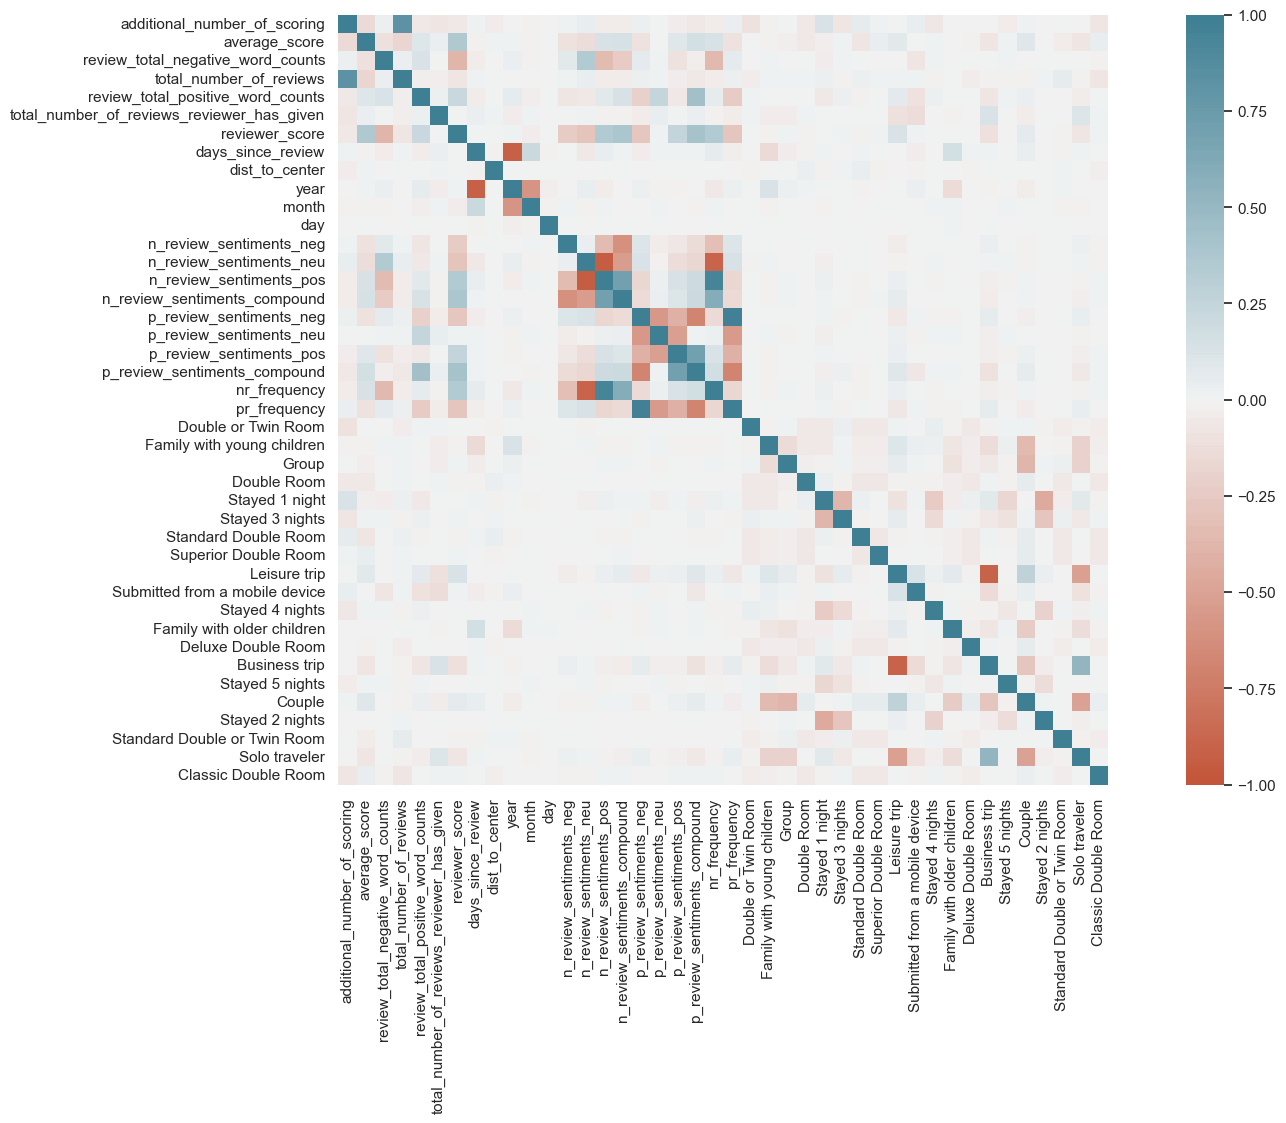

In [76]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = hotels.corr()
sns.set(rc={'figure.figsize':(20, 10)})
ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);
print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:20, :]

Видим, что удивительным образом относительные частоты отзывов сильно скоррелированы с оценкой их эмоциональной окраски.
Удалим относительные частоты отзывов.

In [77]:
hotels.drop(columns=[
    'nr_frequency',
    'pr_frequency'
], inplace=True)

In [79]:
y=y.astype('int')

Проведем обучение модели с помощью LAMA

In [89]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import numpy as np

# Определение констант для lightautoml
N_THREADS = 12
N_FOLDS = 10
RANDOM_STATE = 42
TEST_SIZE = 0.3
TIMEOUT = 200000 # equal to 10 hours
TARGET_NAME = 'reviewer_score'

np.random.seed(RANDOM_STATE)

In [84]:
from sklearn.model_selection import train_test_split


In [85]:
# разбиение на тренировочную и валидационную модели
# tr_data - тренеровочные данные
# te_data - холдаут

tr_data, te_data = train_test_split(
    hotels,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)


In [96]:
# Task - объект из lightautoml
# Определяем какую задачу мы решаем: бинарную 'binary', регрессии 'reg', мультикласс 'multiclass'
# В данном случае регрессия - так как предсказываем вещественное число

task = Task('reg', loss='mae', metric='mae')

# какая колонка является целевой? и какие колонки лишние
roles = {
    'target': TARGET_NAME,
    'drop': []
}

# Создаем объект TabularAutoML

automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={
        'n_jobs': N_THREADS,
        'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)


# Начало обучения модели (на каких данных обучаем, какой target, уровень отображения)
# После выполнения обучения мы получаем Out OF Folde пердсказание

oof_pred = automl.fit_predict(tr_data, roles=roles, verbose=1)


AssertionError: Cannot infer greater is better from metric. Should be set manually.

CPU times: user 114 ms, sys: 5.61 ms, total: 120 ms
Wall time: 117 ms


<AxesSubplot: xlabel='Feature'>

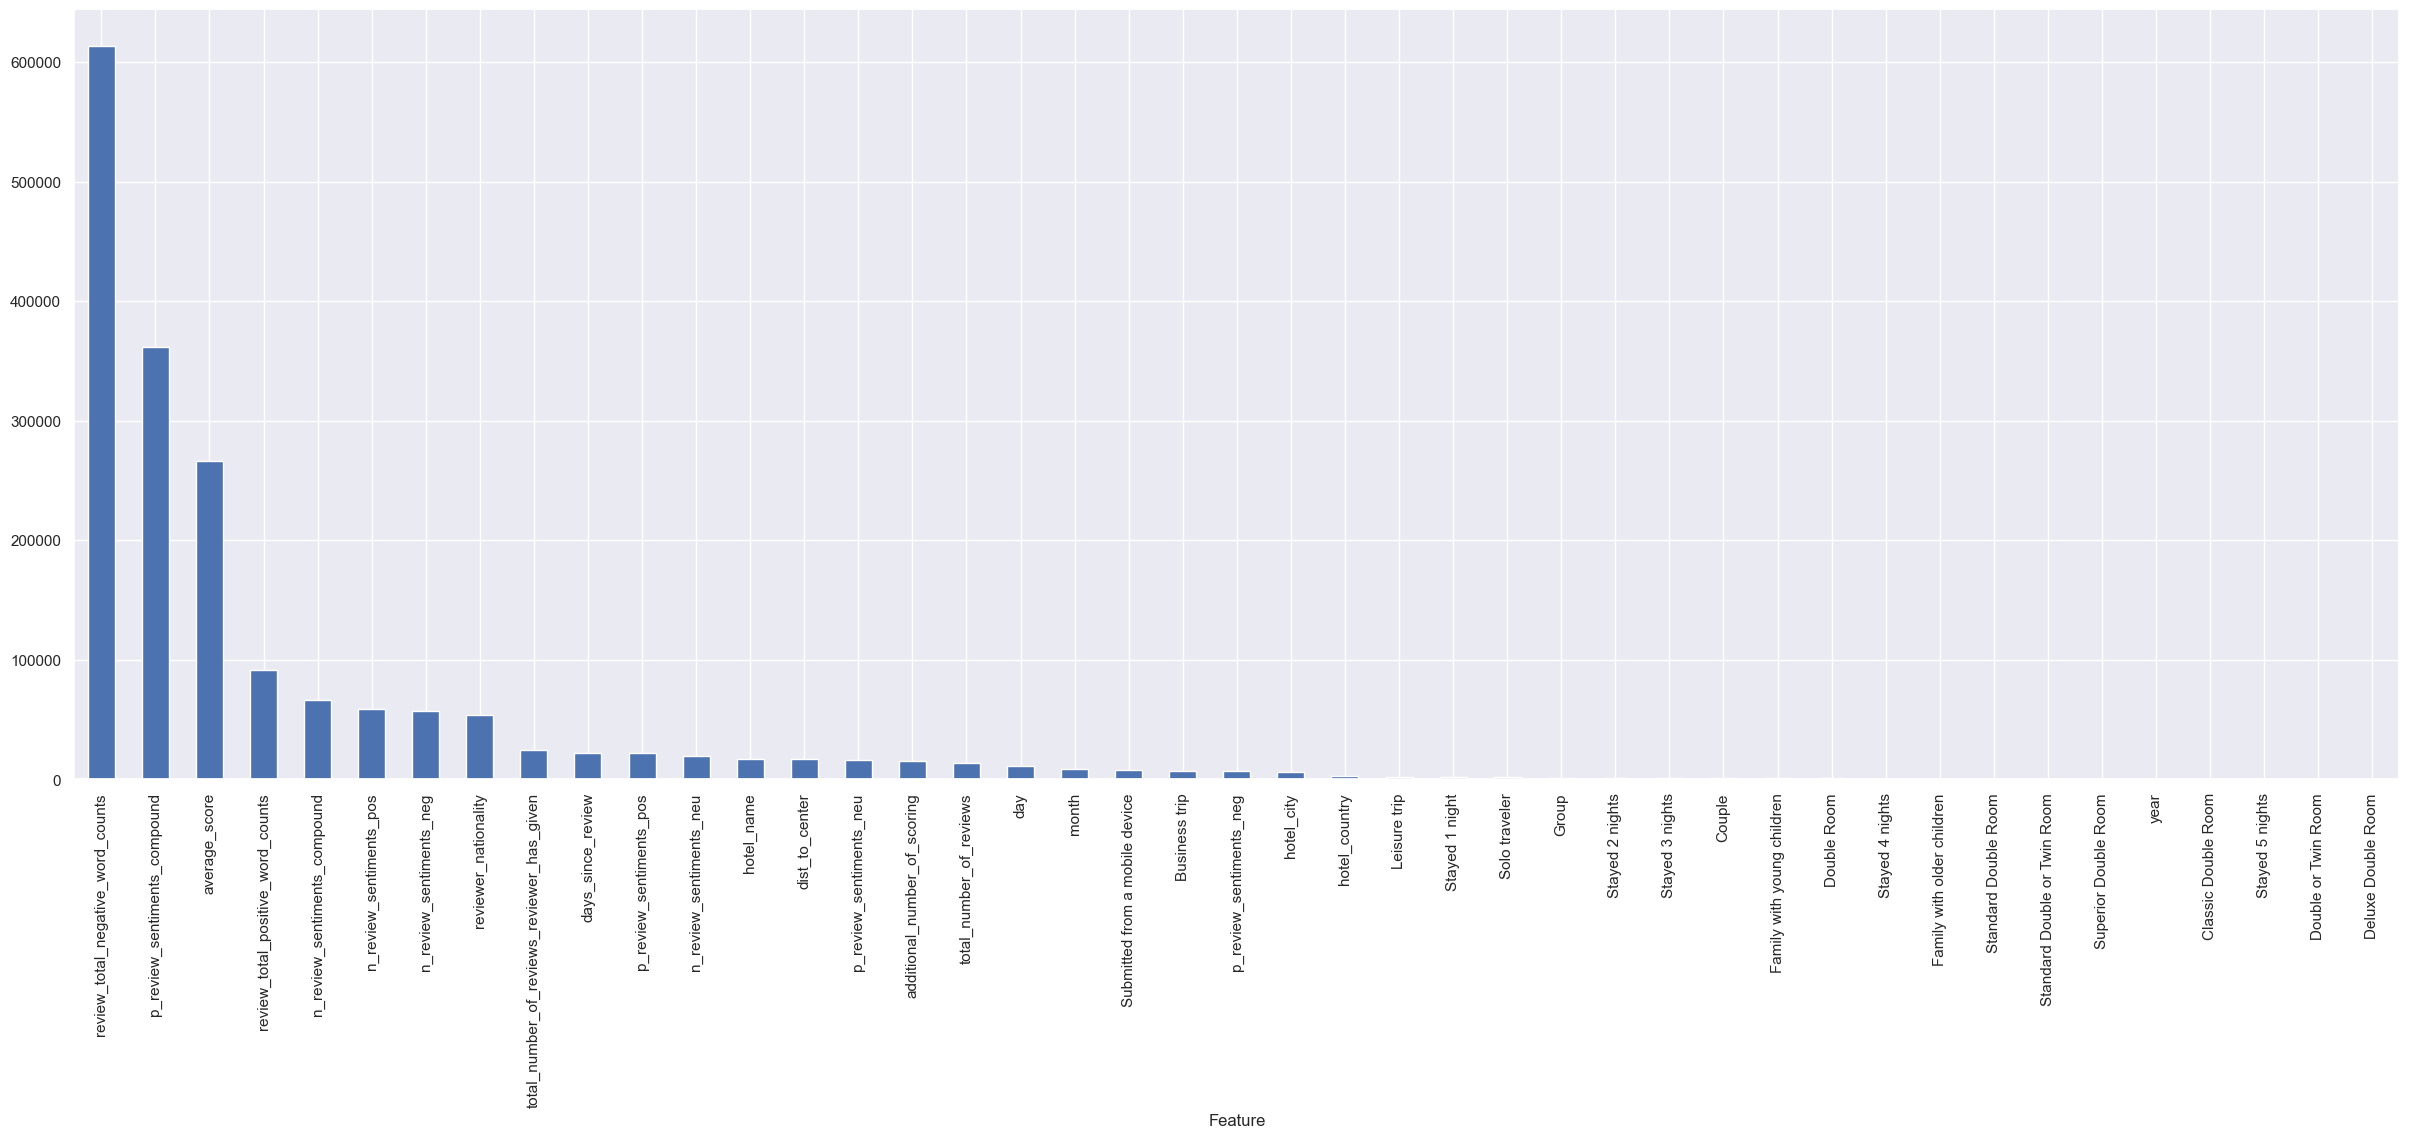

In [95]:
%%time
# Оцениваем важность признаков в графическом виде
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [92]:
# Получаем предсказание на валидационой выборке с помощью функции automl.predict
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[5.0991416],
       [8.086275 ],
       [9.31571  ],
       ...,
       [9.496866 ],
       [7.5652304],
       [9.8251705]], dtype=float32)
Shape = (116041, 1)


In [93]:
from sklearn import metrics  # инструменты для оценки точности модели
#print(f'TRAIN  score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print('MAPE:', metrics.mean_absolute_percentage_error(
    te_data[TARGET_NAME].values, te_pred.data[:, 0]))


MAPE: 0.12121651931197944
